In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from pathlib import Path
import scienceplots

plt.style.use(['science', 'bright'])
plt.rcParams['figure.dpi'] = 300

C:\Users\Julian\AppData\Local\Temp\ipykernel_9228\3452719758.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/models/best_ae_fo

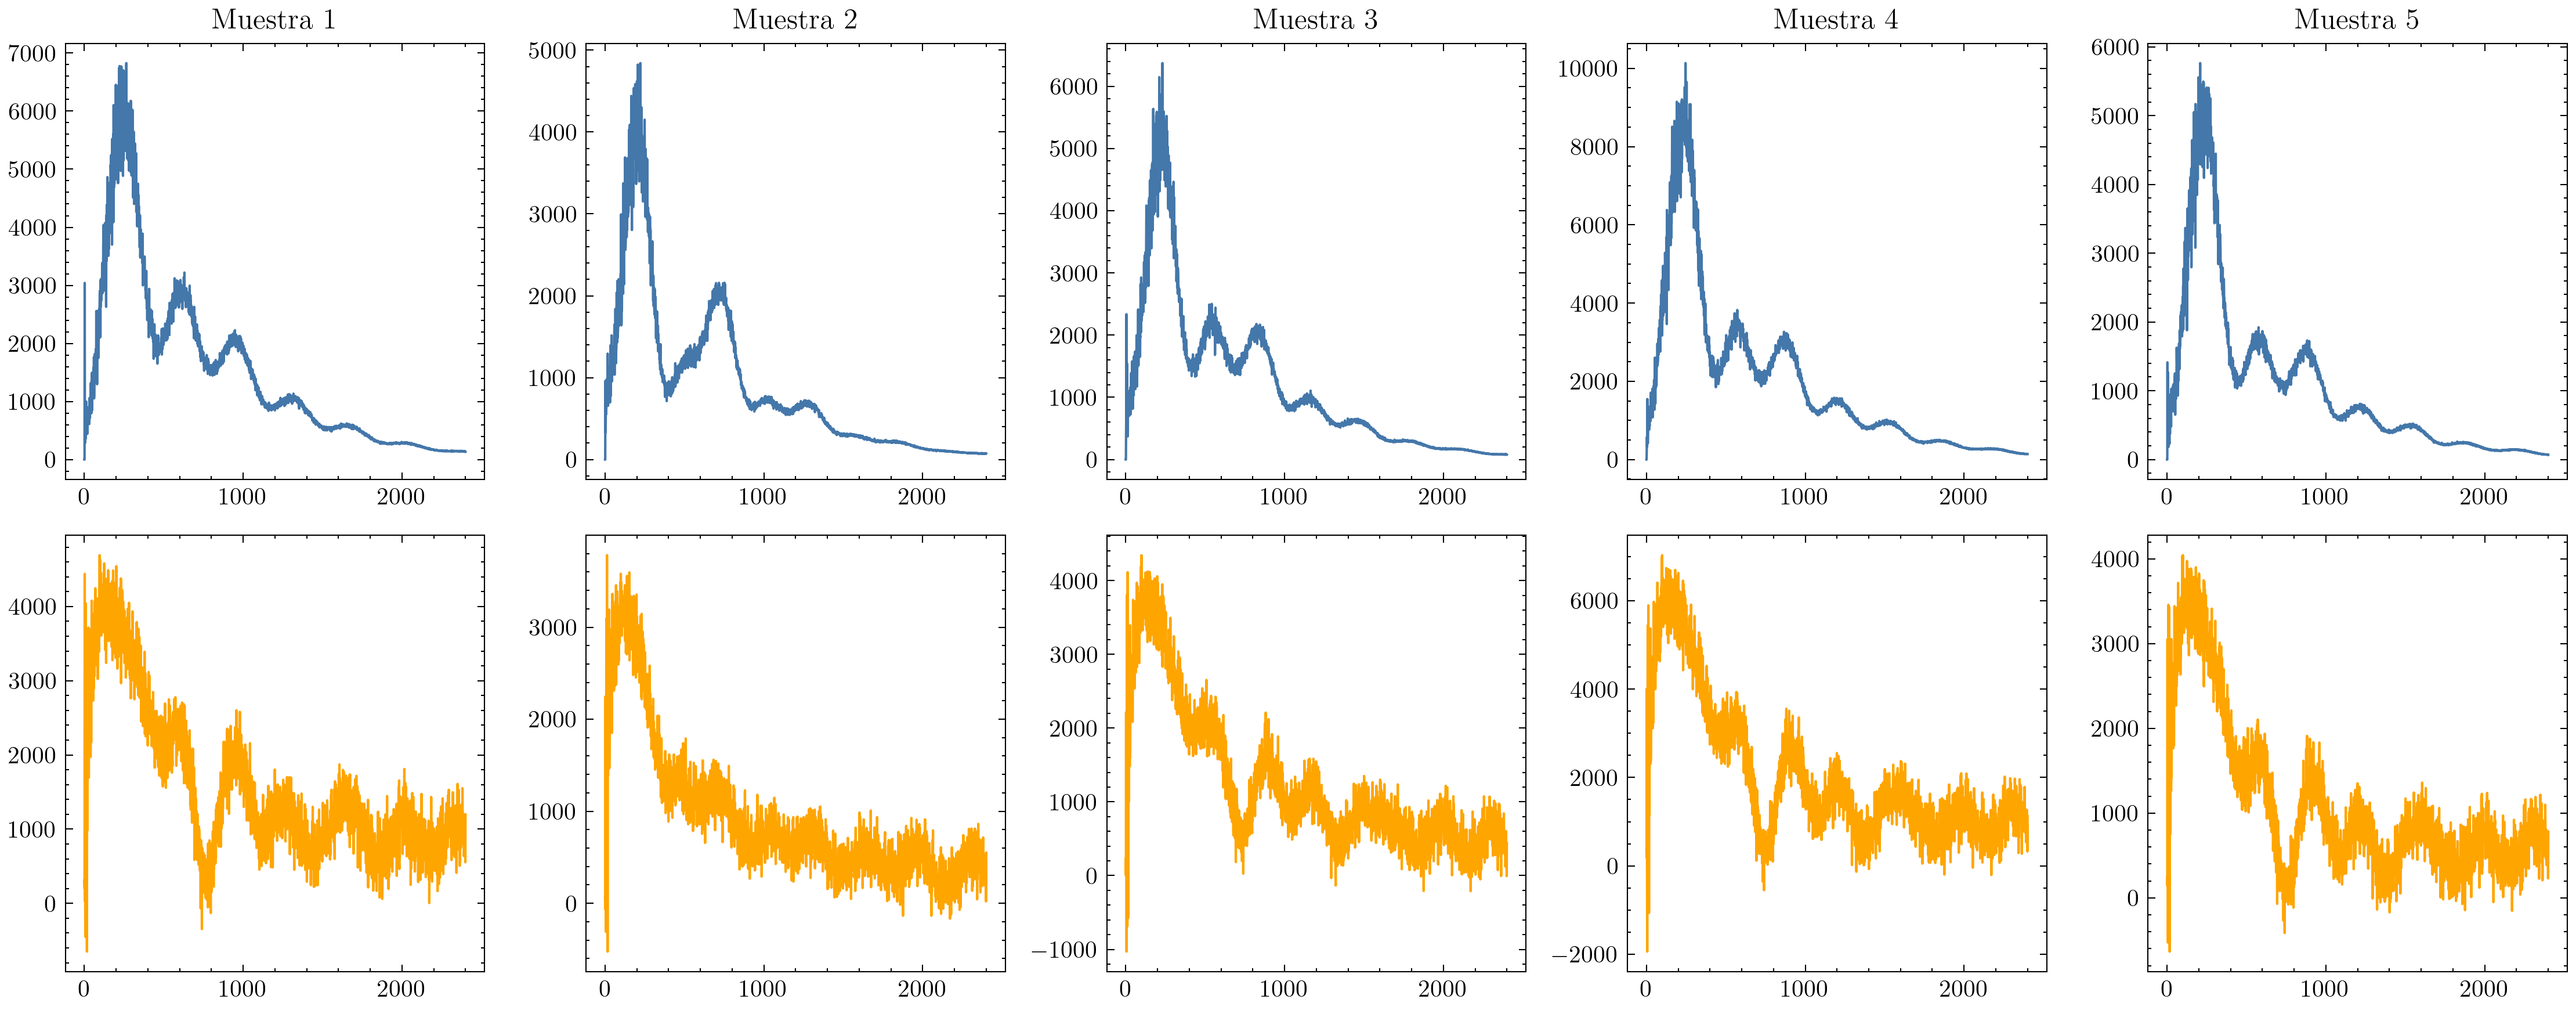

In [13]:
from src.compression.model import CompressionAE
from src.compression.config import DATA_PATHS

def plot_reconstructions(model, data, num_samples=5):
    model.eval()
    with torch.no_grad():
        # Selecciona muestras aleatorias
        indices = torch.randperm(len(data))[:num_samples]
        samples = data[indices]
        reconstructions, _ = model(samples)
        
        # Grafico
        plt.figure(figsize=(15, 6))
        for i in range(num_samples):
            plt.subplot(2, num_samples, i+1)
            plt.plot(samples[i], label="Original")
            plt.title(f"Muestra {i+1}")
            
            plt.subplot(2, num_samples, i+1 + num_samples)
            plt.plot(reconstructions[i], label="Reconstrucción", color='orange')
            
        plt.tight_layout()
        plt.show()

model = CompressionAE(input_size=2401, latent_size=64)
model.load_state_dict(torch.load("results/models/best_ae_fold_1.pth"))  # Carga un modelo
data = torch.load(DATA_PATHS['spectra']).float()  # Datos normalizados
plot_reconstructions(model, data)

In [14]:
# Configuración de paths (ajustar según necesidad)
MODEL_PATH = "results/models/best_ae_fold_1.pth"
DATA_PATH = "data/noise/cmb_observed_TTnoise.pt"

# Cargar un solo espectro de ejemplo
full_data = torch.load(DATA_PATH).float()
sample_spectrum = full_data[0:1]  # Primera realización

# Normalización (usando stats del dataset completo)
spectra_mean = full_data.mean(0)
spectra_std = full_data.std(0)
sample_spectrum = (sample_spectrum - spectra_mean) / (spectra_std + 1e-8)

with torch.no_grad():
    reconstructed, latent = model(sample_spectrum)

C:\Users\Julian\AppData\Local\Temp\ipykernel_9228\2297177453.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  full_data = torch.load(DATA_PATH).float()


In [15]:
# %%
def calculate_compression_metrics(original, reconstructed, latent):
    # Tasa de compresión
    original_size = original.shape[1] * 32  # bits (float32)
    compressed_size = latent.shape[1] * 32
    compression_ratio = original_size / compressed_size
    
    # Error de reconstrucción
    mse = torch.mean((original - reconstructed)**2)
    
    # Cálculo del PSNR corregido
    if mse.item() == 0:  # Evitar división por cero
        psnr = float('inf')
    else:
        psnr = 10 * torch.log10(torch.tensor(1.0) / mse).item()  # Convertir a tensor primero
    
    return {
        'compression_ratio': compression_ratio,
        'mse': mse.item(),
        'psnr': psnr,
        'latent_values': latent.numpy()[0]
    }

metrics = calculate_compression_metrics(sample_spectrum, reconstructed, latent)

print(f"→ Tasa de compresión: {metrics['compression_ratio']:.1f}:1")
print(f"→ Error cuadrático medio (MSE): {metrics['mse']:.2e}")
print(f"→ Relación señal-ruido pico (PSNR): {metrics['psnr']:.2f} dB")
print("\nValores latentes (primeros 5):", metrics['latent_values'][:5])

→ Tasa de compresión: 37.5:1
→ Error cuadrático medio (MSE): 3.95e-03
→ Relación señal-ruido pico (PSNR): 24.03 dB

Valores latentes (primeros 5): [ 1.1476946  -0.05747446  0.31708232  0.9740515  -0.20473301]


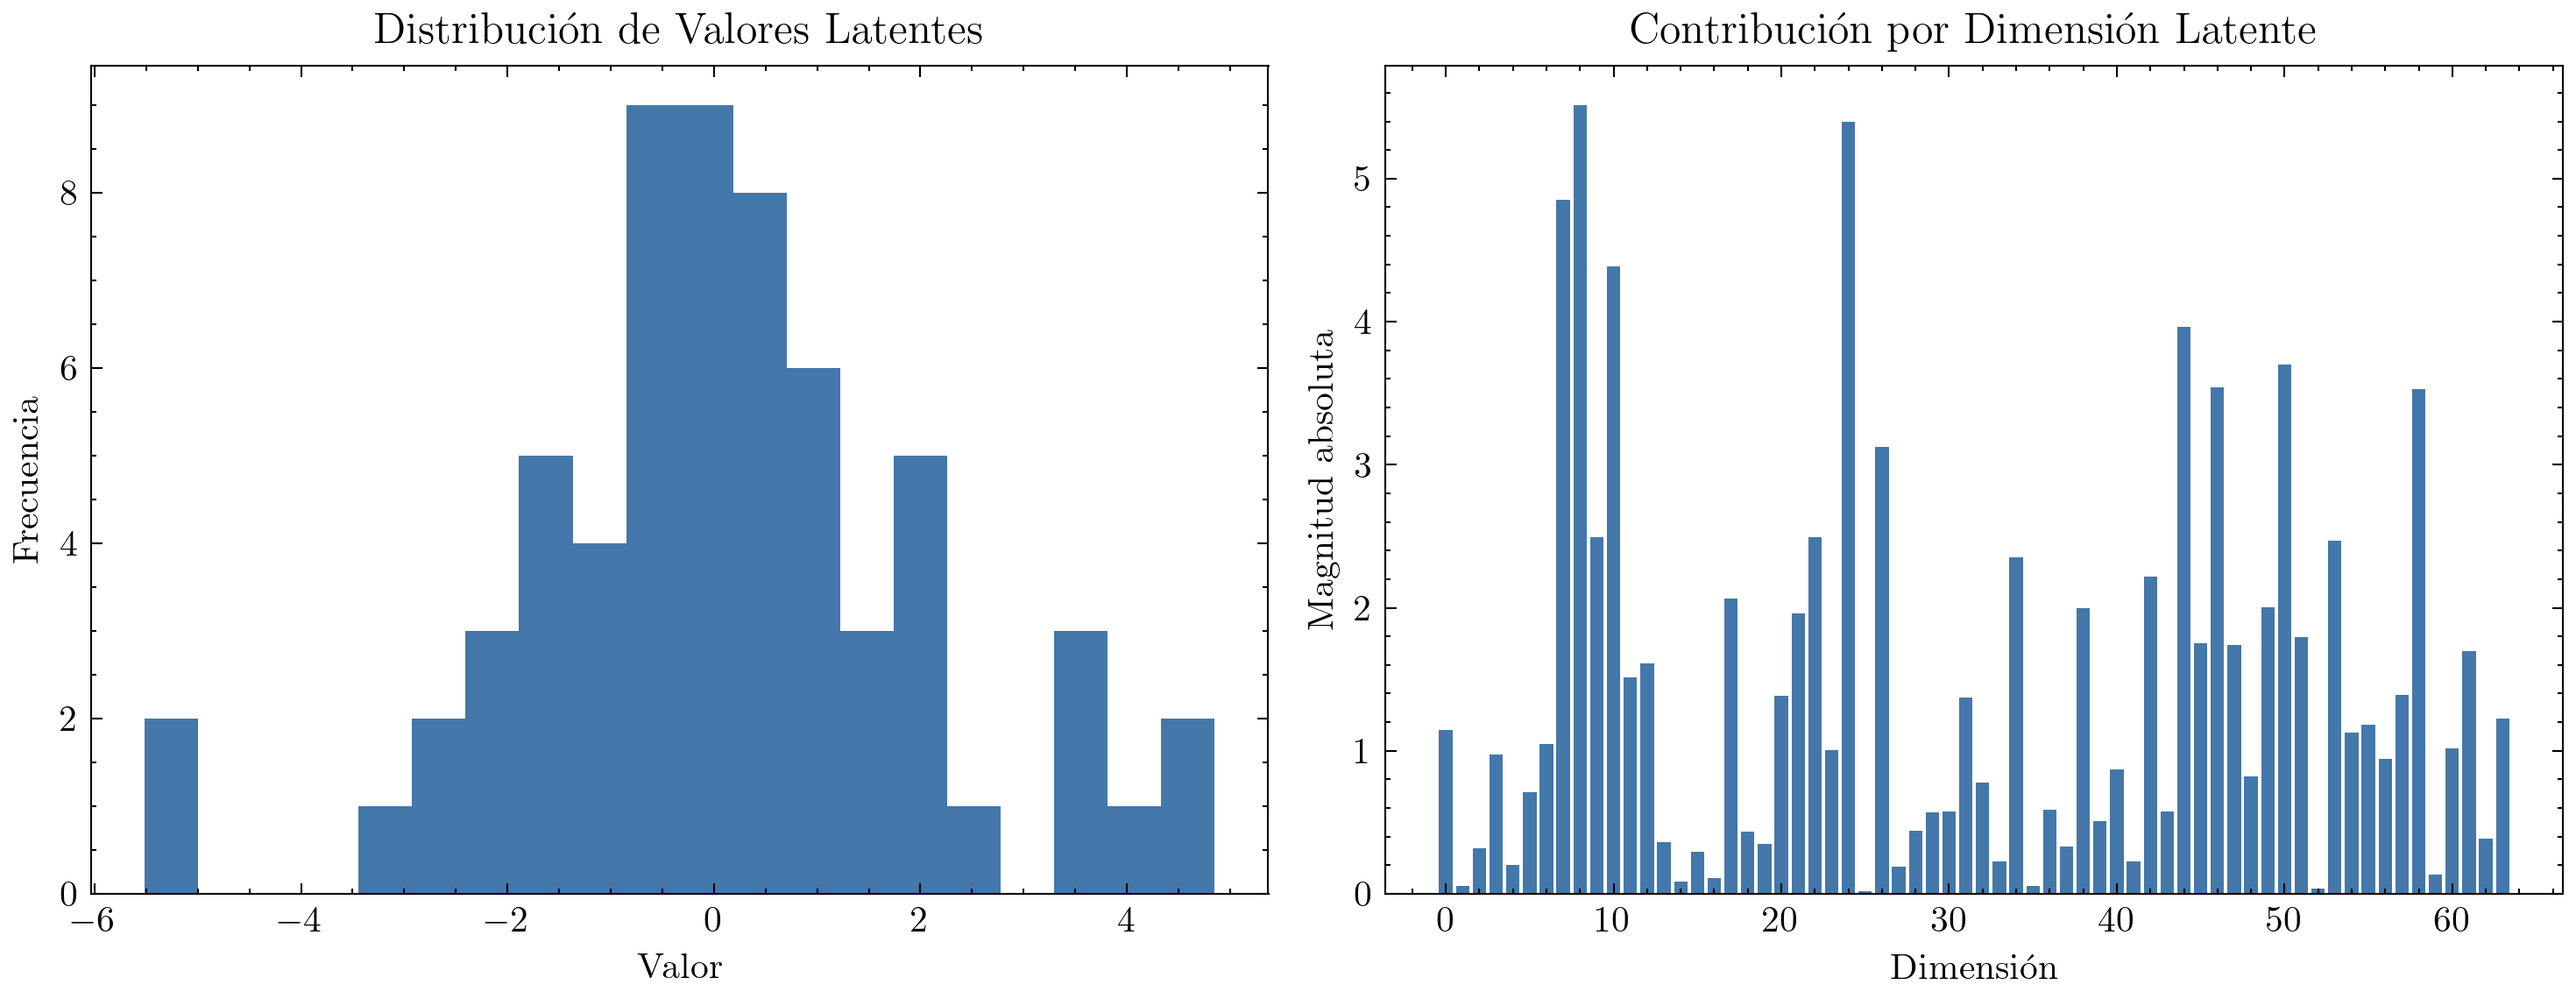


Estadísticas del vector latente:
mean: 0.0992
std: 1.9752
min: -5.5161
max: 4.8520


In [17]:
def analyze_latent_space(latent_vector):
    latent_stats = {
        'mean': np.mean(latent_vector),
        'std': np.std(latent_vector),
        'min': np.min(latent_vector),
        'max': np.max(latent_vector)
    }
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(latent_vector, bins=20)
    plt.title("Distribución de Valores Latentes")
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    
    plt.subplot(1, 2, 2)
    plt.bar(range(len(latent_vector)), np.abs(latent_vector))
    plt.title("Contribución por Dimensión Latente")
    plt.xlabel("Dimensión")
    plt.ylabel("Magnitud absoluta")
    
    plt.tight_layout()
    plt.show()
    
    return latent_stats

latent_stats = analyze_latent_space(metrics['latent_values'])
print("\nEstadísticas del vector latente:")
for k, v in latent_stats.items():
    print(f"{k}: {v:.4f}")